In [2]:
#basic imports and ipython setup
import matplotlib.pyplot as plt
import numpy as np

import os.path

from MCEq.core import MCEqRun
import mceq_config as config
import crflux.models as pm

from tqdm import tqdm

import pandas as pd
from MCEq.geometry.density_profiles import GeneralizedTarget

import matplotlib as mpl
from cycler import cycler

In [3]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

### Model matrices
$M^{\pm}(\mu,z_0,E_\mu, E_0)$: Muon longitudinal production matrix ($\mu^+$, $\mu^-$)

$\sigma(i, E_\mu)$: Fast muon cross section ($\sigma = \sigma_0 E_\mu^\alpha$)

$f_{tot}(i, E_\mu)$: Combined negative capture production factor ($f_{tot} = f_C f_D f^*$)

$F(f,m)$: $^{14}$CO production matrix (f_factors)

$U(u, z_0, z_f)$: $^{14}$CO flow matrix

$S(z_f,z_s)$: Ice core sample matrix


### Independent Variables
$\Phi_0(p,E_0,t)$: Primary CR intensity matrix


### Parameters
$t$ - time (bin)

$z_0$ - interaction depth (bin)

$z_f$ - measured depth (bin)

$z_s$ - sample depth (bin)

$h$ - mass depth (bin)

$E_\mu$ - muon energy (bin)

$E_0$ - primary energy (bin)

$p$ - Primary CR model (Energy spectra, Time dependence)

$\mu$ - Muon production model (Atmospheric model, Underground model)

$i$ - $^{14}$C interaction model (cross-section, negative capture, energy dependence)

$m$ - $^{14}$C production mode (neg, fast)

$f$ - $^{14}$CO production model (f_factors)

$u$ - $^{14}$CO flow model

$N$ - Oxygen number density in ice


### Derived Quantities
$^{14}$C Interaction Matrices:
\begin{align*}
    I_{\text{neg}}(\mu,z_0,i,E_0) &= - \frac{d}{dh}(f_{tot} \cdot M^-) * \frac{60*60*24*365.25}{100}\\
    I_{\text{fast}}(\mu,z_0,i,E_0) &= N \sigma \cdot (M^+ + M^-) * \frac{60*60*24*365.25}{100}\\
    I_{14C}(\mu,i,z_0,m,E_0) &= [I_{\text{neg}}, I_{\text{fast}}]\text{.swapaxes(0,-2)}\\
    I_{14CO}(\mu,i,f,?,z_0,E_0) &= (F \cdot I_{14C})\text{.swapaxes(2,3) + axis-3}
\end{align*}

$^{14}$CO Production Rates:
\begin{align*}
    P(\mu,i,f,?,p,z_0,t) = I_{14CO} \cdot \Phi_0\text{ + axis-3}
\end{align*}

$^{14}$CO Density Profiles:
\begin{align*}
    ^{14}CO(\mu,i,f,u,p,z_f) &= \sum_t P(t) \cdot U^{t_f-t}\, dt\\
    ^{14}CO_s(\mu,i,f,u,p,z_s) &=\, ^{14}CO \cdot S
\end{align*}

## Setup Grid Parameters

In [4]:
age_scale_file = 'DomeC_age_scale_Apr2023.csv' # relationship between age and depth of ice at Dome-C
ice_eq_depth_file = 'Real_vs_ice_eq_depth.csv' # relationship bewteen ice-equivalent-depth and real-depth at Dome-C

# read age-scale file
age_scale = pd.read_csv(age_scale_file)
ages = np.array(age_scale['ages']) # years
depths_real = np.array(age_scale['depths_real']) # meters

# read ice-eq-depth file
ice_eq_depth = pd.read_csv(ice_eq_depth_file)
real_z = ice_eq_depth['z'] # meters
ice_eq_z = ice_eq_depth['ice_eq_z'] # meters (ice-eq) aka mass-depth / ice density

In [5]:
rho_ice = 0.9239 # density of solid ice at Dome C (g/cm^3)

def z_to_t(z): # convert real depth to age
    return np.interp(z, depths_real, ages)

def t_to_z(t): # convert age to real depth
    return np.interp(t, ages, depths_real)

def z_to_h(z): # convert real depth to mass depth
    return np.interp(z, real_z, ice_eq_z)*rho_ice

def h_to_z(h): # convert mass depth to real depth
    return np.interp(h/rho_ice, ice_eq_z, real_z)

def h_to_t(h): # convert mass depth to age
    return z_to_t(h_to_z(h/rho_ice))

def t_to_h(t): # convert age to mass depth
    return z_to_h(t_to_z(t))*rho_ice

In [11]:
def argnear_below(x, a): #assuming sorted low -> high
    return max(min(int(np.interp(x, a, np.arange(len(a)))), len(a)-1), 0)

def argnear_above(x, a): #assuming sorted low -> high
    return max(min(int(np.interp(x, a, np.arange(len(a))))+1, len(a)-1), 0)

In [27]:
z_min = 0 # starting depth for plots (m)
z_deep = 300 # end depth (m)

i_min = argnear_below(z_min, depths_real) # nearest depths_real index to z_min
i_end = argnear_above(z_deep, depths_real) # nearest depths_real index to z_end

In [28]:
# Define depth bins
z_bins = depths_real[i_min:i_end+1] # depth bin edges in steps of 1-year ice age (m)
z = (z_bins[:-1]+z_bins[1:])/2 # bin-average of z (m)
dz = np.diff(z_bins) # bin-width of z (m)

# Define mass depth bins
h_bins = z_to_h(z_bins) # mass depth bin edges corresponding to z bins (m.w.e = hg/cm^2)
h = (h_bins[:-1]+h_bins[1:])/2 # bin-average of h (m.w.e = hg/cm^2)
dh = np.diff(h_bins) # bin-width of h (m.w.e = hg/cm^2)

rho = dh/dz # density of depth bins

# Define time bins
t_bins = z_to_t(z_bins) # ice age bins corresponding to z array (years)
t = (t_bins[:-1]+t_bins[1:])/2 # bin-average of t (years)
dt = np.diff(t_bins) # bin-width of t (years)

In [50]:
z_start = 96.5 # starting depth of 14C accumulation (m) - close-off depth beneath firn layer
sample_length = 20 # length of ice core samples (m)

i_start = argnear_below(z_start, z_bins) # index of first bin beneath starting point for 14C accumulation

z_samp_ideal = np.arange(z_bins[i_start],z_bins[-1],sample_length)
i_samp = np.append(np.argmin(abs(z_bins.reshape((1,-1))-z_samp_ideal.reshape(-1,1)), axis=1), len(z_bins)-1)
i_samp[0] = i_start # just making sure

# Define sample depth bins
z_samp_bins = z_bins[i_samp] # sample depth bin edges (m)
z_samp = (z_samp_bins[:-1]+z_samp_bins[1:])/2 # bin-average of sample depth (m)
dz_samp = np.diff(z_samp_bins) # bin-width of sample depth (m)

# Define sample compression matrix
dh_samp = np.zeros(len(i_samp)-1)
S_mat = np.zeros((len(z_bins)-1, len(i_samp)-1))
for i in range(len(i_samp)-1):
    dh_samp[i] = np.sum(dh[i_samp[i]:i_samp[i+1]])
    S_mat[i_samp[i]:i_samp[i+1], i] = dh[i_samp[i]:i_samp[i+1]]/dh_samp[i]

In [31]:
N_ang = 10

# Define zenith angle bins
cosTH_bins = np.linspace(1,0,N_ang+1)
cosTH = (cosTH_bins[:-1]+cosTH_bins[1:])/2
dcosTH = np.diff(cosTH_bins)

In [32]:
logE_min = -1 # minimum energy (log10 GeV)
logE_max = 11 # maximum energy (log10 GeV)
dlogE = 0.1 # energy bin width (log10 GeV)

# Define energy bins
logE_bins = np.arange(logE_min, logE_max+dlogE, dlogE) # log10 GeV
logE = (logE_bins[:-1]+logE_bins[1:])/2 # log10 GeV
E_bins = 10.**(logE_bins) # GeV
E = 10.**(logE) # bin-average of E (GeV)
dE = np.diff(E_bins) # bin-width of E (GeV)

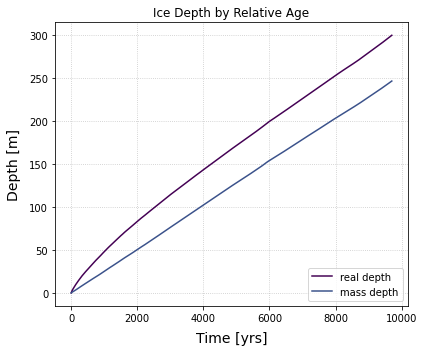

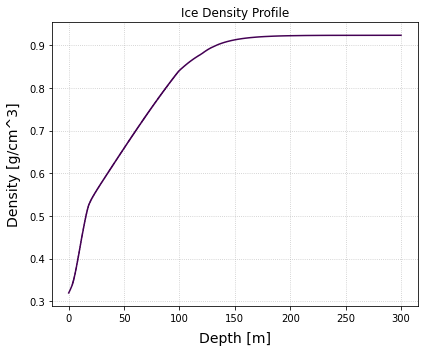

In [33]:
# Plot depth, mass depth, and time
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, z, label='real depth')
ax.plot(t, h, label='mass depth')
ax.set(xlabel='Time [yrs]',
       ylabel='Depth [m]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Depth by Relative Age')
plt.show()

# Plot density
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(z, rho)
ax.set(xlabel='Depth [m]',
       ylabel='Density [g/cm^3]')
#ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Density Profile')
plt.show()

In [8]:
def surface_flux(cosTH, primary_model = (pm.GlobalSplineFitBeta, None), interaction_model = 'DPMJETIII191', density_model = ('CORSIKA',('SouthPole', 'December')), elev = 3120, sol=True, use_tqdm=False):
    """ Sets up and runs an atmospheric MCEq calculation
    
    Parameters
    -----------
    cosTH : float bounded by (0., 1.]
        cosine of zenith angle
    
    primary_model : tuple
        MCEq primary model
        
    interaction_model : string
        MCEq interaction model
    
    density_model : tuple
        MCEq density model
        
    elev : int or float
        surface elevation in meters
        
    sol : bool
        Whether or not to solve the MCEq before returning
        
    use_tqdm : bool
        If True, runs a tqdm progress bar during integration
        
        
    Returns
    --------
    mceq : MCEqRun object
        MCEq instance specified by inputs
    """
    # configure MCEq
    import mceq_config as config
    
    config.debug_level = 0
    
    config.h_obs = elev # elevation in (m) of Dome-C
    
    config.enable_default_tracking = False
    
    #density_model = ('CORSIKA',('SouthPole', 'June'))
    #density_model = ('CORSIKA',('SouthPole', 'December'))
    #density_model = ('CORSIKA', ('USStd', None))
    
    config.max_density = 0.001225
    config.dedx_material = 'air'

    # initialize MCEq
    mceq = MCEqRun(
        interaction_model=interaction_model,
        theta_deg = 180*np.arccos(cosTH)/np.pi,
        density_model = density_model,
        #medium=medium,
        primary_model = primary_model,
    )
    
    if sol: # solve MCEq
        #mceq.solve()
        
        solve_mceq(mceq, use_tqdm=use_tqdm)
    
    return mceq

In [9]:
def depth_flux(flux, z, h, cosTH, rho, interaction_model = 'DPMJETIII191', sol=True, use_tqdm=False):
    """ Sets up and runs an underground ice MCEq calculation
    
    Parameters
    -----------
    flux : array of floats, final axis must match mceq._phi0
        incoming particle flux
        
    z : 1d array of floats
        initial depths of target material density bins, in meters
    
    h : 1d array of floats
        grid solution depths, in m.w.e. (hg/cm^2)
    
    cosTH : float bounded by (0., 1.]
        cosine of zenith angle
        
    rho : 1d array of floats, same size as z
        target material densities, in g/cm^3
        
    interaction_model : string
        MCEq interaction model
        
    sol : bool
        Whether or not to solve the MCEq before returning
        
    use_tqdm : bool
        If True, runs a tqdm progress bar during integration
        
        
    Returns
    --------
    mceq : MCEqRun object
        MCEq instance specified by inputs
    """
    # configure MCEq
    import mceq_config as config
    
    config.enable_default_tracking = False
    
    config.debug_level = 0 #2
    
    primary_model = (pm.GlobalSplineFitBeta, None)
    
    medium = 'ice'
    rho_ice = 0.9239 # density of solid ice at Dome C (g/cm^3)
    
    # setup ice density profile
    target = GeneralizedTarget(len_target=z[-1]*100/cosTH, env_density = rho_ice, env_name = 'ice')
    # manually enter all density layers at once because doing it one-by-one takes forever
    target.mat_list = [[z[i]*100/cosTH, z[i+1]*100/cosTH, rho[i], 'ice'] for i in range(len(z)-1)]
    target._update_variables()
        
    config.max_density = 0.9239
    config.dedx_material = 'ice'
    
    # initialize MCEq
    mceq = MCEqRun(
        interaction_model = interaction_model,
        theta_deg = 0,
        density_model = target,
        medium=medium,
        primary_model = primary_model,
    )

    mceq._phi0 = flux # set initial particle flux
    
    if sol: # solve MCEq
        #mceq.solve(int_grid=h/cosTH*100)
        
        solve_mceq(mceq, int_grid=h/cosTH*100, use_tqdm=use_tqdm)
    
    return mceq

In [10]:
def solve_mceq(mceq, int_grid=None, grid_var='X', use_tqdm=False):
    """ Runs numpy solver of MCEq, zeroing out values below 1e-250
    
    Parameters
    -----------
    mceq : MCEqRun object
        MCEq instance to be solved
    
    int_grid : 1d array of floats or None
        grid solution depths, in cm.w.e (g/cm^2)
    
    grid_var : str
        No idea what this does, just send it into mceq._calculate_integration_path
        
    use_tqdm : bool
        If True, runs a tqdm progress bar during integration
    """
    # Calculation is identical to MCEq numpy solver, except where noted
    
    mceq._calculate_integration_path(int_grid=int_grid, grid_var=grid_var)

    nsteps, dX, rho_inv, grid_idcs = mceq.integration_path
    int_m = mceq.int_m
    dec_m = mceq.dec_m

    dXaccum = 0.
    grid_sol = np.zeros((len(grid_idcs), *np.shape(mceq._phi0))) # grid_sol begins with the right shape, to avoid restructuring
    grid_step = 0

    phc = np.copy(mceq._phi0)
    
    for step in (tqdm(range(nsteps)) if use_tqdm else range(nsteps)): # added option for tqdm progress bar
        phc += (int_m.dot(phc) + dec_m.dot(rho_inv[step] * phc)) * dX[step]
        phc[phc<1e-250] = 0. # exreme low values set to 0, improving efficiency for large slant depths

        if (grid_idcs and grid_step < len(grid_idcs)
                and grid_idcs[grid_step] == step):
            grid_sol[grid_step] = np.copy(phc) # grid_sol no longer appends
            grid_step += 1

    mceq._solution, mceq.grid_sol = phc, grid_sol
    
    return

In [21]:
def flux_matrix_one_ang(particles, z, h, cosTH, rho, interaction_model = 'DPMJETIII191', density_model=('CORSIKA',('SouthPole', 'December')), elev = 3120, surf=True, depth=True):
    """ Solves for the muon spectrum from every possible primary particle energy, at a specific zenith angle
    
    Parameters
    -----------
    particles : 1d array of strings
        Names of primary particles used as input spectrum
        
    z : 1d array of floats
        initial depths of target material density bins, in meters
    
    h : 1d array of floats
        grid solution depths, in m.w.e. (hg/cm^2)
    
    cosTH : float bounded by (0., 1.]
        cosine of zenith angle
        
    rho : 1d array of floats, same size as z
        target material densities, in g/cm^3
        
    interaction_model : string
        MCEq interaction model
        
    elev : int or float
        surface elevation in meters
        
    surf : bool
        if False, skips atmospheric interactions
    
    depth : bool
        if False, skips underground ice interactions
        
    Returns
    --------
    phi_int : array of floats
        Muon spectra produced by primary particles, in #particles /cm^2 /sr /s
        axis0 : depth
        axis1 : muon energy
        axis2 : CR particle & energy
    """
    
    print('Calculating muon flux response at {:.1f} degrees'.format(180*np.arccos(cosTH)/np.pi))
    
    # initialize atmospheric MCEq
    mceq = surface_flux(cosTH, interaction_model=interaction_model, density_model=density_model, elev=elev, sol=False)
    
    pname = mceq.pman.pname2pref # reference for particle names and indices
    
    # range of particle indices used as primaries
    i_range = np.concatenate([np.arange(pname[p].lidx, pname[p].uidx) for p in particles])
    
    # setup 2d matrix of single-source fluxes
    phi0 = np.zeros((len(mceq._phi0), len(i_range))) # empty matrix
    phi0[i_range,np.arange(len(i_range))] = 1. # set flux=1 for a single primary particle energy per spectrum
    # axis0 : all particles & energies
    # axis1 : primary particles & energies
    
    if surf:
        print('Propagating through atmosphere...')
        # solve atmospheric MCEq for surface flux
        mceq._phi0 = phi0
        solve_mceq(mceq, use_tqdm=True)
    else:
        # skip atmospheric calculation
        mceq._solution = phi0
    
    if depth:
        print('Propagating through ice...')
        # solve in-ice MCEq for underground flux

        mceq_fin = depth_flux(mceq._solution, z, h, cosTH, rho, interaction_model = interaction_model, use_tqdm=True)
        
        print('Retrieving Muon Flux...')
        
        # calculate underground muon flux
        phi_sum = np.sum([mceq_fin.grid_sol[:, pname[mu].lidx:pname[mu].uidx] for mu in ['mu+_l', 'mu+', 'mu+_r', 'mu-_l', 'mu-', 'mu-_r']], axis=0) # sum all muon fluxes
        phi_int = phi_sum * mceq_fin._energy_grid.w.reshape((1,-1,1)) # multiply differential muon flux by energy bin width
    else:
        # skip in-ice calculation
        
        print('Retrieving Muon Flux...')
        
        # calculate surface flux
        phi_sum = np.sum([mceq._solution[pname[mu].lidx:pname[mu].uidx] for mu in ['mu+_l', 'mu+', 'mu+_r', 'mu-_l', 'mu-', 'mu-_r']], axis=0) # sum all muon fluxes
        phi_int = phi_sum * mceq._energy_grid.w.reshape((-1,1)) # multiply differential muon flux by energy bin width
        
    return phi_int

In [11]:
def flux_matrix_all(particles, z, h, cosTH, dcosTH, rho, interaction_model = 'DPMJETIII191', density_model=('CORSIKA',('SouthPole', 'December')), elev = 3120, surf=True, depth=True):
    """ Solves for the muon spectrum from every possible primary particle energy, integrated over a range of zenith angles
    
    Parameters
    -----------
    particles : 1d array of strings
        Names of primary particles used as input spectrum
        
    z : 1d array of floats
        initial depths of target material density bins, in meters
    
    h : 1d array of floats
        grid solution depths, in m.w.e. (hg/cm^2)
    
    cosTH : 1d array of floats
        cosine of zenith angle
        
    dcosTH : float or 1d array of floats (same size as cosTH)
        bin width of cosTH
        
    rho : 1d array of floats, same size as z
        target material densities, in g/cm^3
        
    interaction_model : string
        MCEq interaction model
        
    elev : int or float
        surface elevation in meters
        
    surf : bool
        if False, skips atmospheric interactions
    
    depth : bool
        if False, skips underground ice interactions and returns surface spectrum without integrating over cosTH
        
    Returns
    --------
    phi_int : array of floats
        Muon spectra produced by primary particles, in #particles /cm^2 /sr /s
        axis0 : depth
        axis1 : muon energy
        axis2 : CR particle & energy
    """
    
    if not (surf and depth):
        # calculate surface spectrum over cosTH range
        return np.array([flux_matrix_one_ang(particles, z, h, cth, rho, interaction_model = interaction_model, density_model=density_model, elev = elev, surf=surf, depth=depth) for cth in cosTH])
    else:
        # integrate longitudinal muon spectrum over cosTH range
        phi_mu_tot = flux_matrix_one_ang(particles, z, h, cosTH[0], rho, interaction_model = interaction_model, density_model=density_model, elev = elev, surf=surf, depth=depth)
        phi_mu_tot *= dcosTH
        for i in range(1,len(cosTH)):
            phi_mu_tot += flux_matrix_one_ang(particles, z, h, cosTH[i], rho, interaction_model = interaction_model, density_model=density_model, elev = elev, surf=surf, depth=depth) * dcosTH
    
    return 2*np.pi*phi_mu_tot

In [12]:
mceq = surface_flux(1, interaction_model='SIBYLL-2.3c', sol=False)
E_grid = mceq._energy_grid.c

In [13]:
# Setup range of zenith angles for integration to total flux
dcosTH = 0.1
cosTH = np.arange(1,0,-dcosTH)-dcosTH/2 # cosines of zenith angles in evenly space bins

elev = 3120

mu0 = [['p+','n0'], h, cosTH, dcosTH, rho, 'SIBYLL-2.3c', ('CORSIKA',('SouthPole', 'December')), elev]

def get_Mu_matrix(params = [mu0], z=z): # longitudinal muon production
    """
    """
    return np.array([flux_matrix_all(p[0], z, p[1], p[2], p[3], p[4], p[5], p[6], p[7]) for p in params])

In [14]:
# Fast Muon Interaction parameters (Heisinger)
sigma_190, dsigma_190 = 4.5e-28, 2.5e-28 #cm^2
alpha = 0.75

# Negative Muon Capture parameters (Heisinger)
f_C = 1 # value should be absolute
f_D = 0.1828 #error unknown
f_star, df_star = 0.137, 0.011 

i0 = [sigma_190, alpha, f_C, f_D, f_star]

def get_sigma(params = [i0], E_mu=E_grid): # fast interaction cross section
    """
    
    """
    p = np.array(params)
    E = np.array([E_mu])
    sigma_190 = p[:,0]
    alpha = p[:,1]
    return sigma_190 * (E/190)**alpha

def get_f_tot(params = [i0], E_mu=E_grid): # negative capture production factor
    """
    
    """
    p = np.array(params)
    E = np.array([E_mu])
    f_C = p[:,2]
    f_D = p[:,3]
    f_star = p[:,4]
    return f_C * f_D * f_star + 0*E

In [15]:
f_neg = 0.066
f_fast = 0.072

f0 = [f_neg, f_fast]

def get_F_matrix(params = [f0]): # 14CO production factors
    """
    """
    return np.array(params)

In [17]:
# Decay parameter
lambd=1.21e-4 #yr^-1

u0 = [lambd]

def get_U_matrix(params = [u0], z=z[i_int], t=t[i_int]): # 14C flow
    """
    """
    return np.array([np.diag(np.full(len(z)-1, 1-p[0]),1) for p in params])

def diag_sum(A, off=None, axis1=-2, axis2=-1):
    # sums along the upper diagonals of two axes in an array
    # the new axis replaces axis1; axis2 is eliminated.
    if off==None:
        off = np.flip(range(np.shape(A)[axis2]))
    return np.moveaxis(np.array([np.trace(A, offset=i, axis1=axis1, axis2=axis2) for i in off]), 0, axis1 if axis1>=0 else axis1+1)

def flow(phi, t=t[i_int], dt=dt, lambd=lambd):
    """
    """
    lambda_dt = (1-lambd)**(t[-1]-t) * dt
    return diag_sum(phi * lambda_dt).swapaxes(0,-2)

In [18]:
depth_avg = 20
z_bins = np.append(np.arange(z_start, z_deep, depth_avg), z_deep)
i_bins = np.argmin(abs(depths_real[i_int].reshape((-1,1))-z_bins.reshape((1,-1))), axis=0)
i_bins[-1] += 1

dh_core = np.zeros(len(i_bins)-1)
core_mat = np.zeros((len(i_int), len(i_bins)-1))
for i in range(len(i_bins)-1):
    dh_core[i] = np.sum(dh[i_int][i_bins[i]:i_bins[i+1]])
    core_mat[i_bins[i]:i_bins[i+1], i] = dh[i_int][i_bins[i]:i_bins[i+1]]/dh_core[i]

z_samp = z[i_int] @ core_mat

def get_S_matrix(depth_avg=depth_avg, z_bins=z_bins, i_bins=i_bins, dh=dh, i_int=i_int): # ice core sample averages
    """
    """
    dh_s = np.zeros(len(i_bins)-1)
    S_mat = np.zeros((len(i_int), len(i_bins)-1))
    for i in range(len(i_bins)-1):
        dh_s[i] = np.sum(dh[i_int][i_bins[i]:i_bins[i+1]])
        S_mat[i_bins[i]:i_bins[i+1], i] = dh[i_int][i_bins[i]:i_bins[i+1]]/dh_s[i]
    return S_mat

In [19]:
p_models = [(pm.GlobalSplineFitBeta, None), (pm.HillasGaisser2012, "H3a"), (pm.HillasGaisser2012, "H4a"), (pm.PolyGonato, False),
           (pm.GaisserStanevTilav, "3-gen"), (pm.GaisserStanevTilav, "4-gen"), (pm.CombinedGHandHG, "H3a"),
           (pm.ZatsepinSokolskaya, "pamela"), (pm.ZatsepinSokolskaya, "default"), (pm.GaisserHonda, None),
           (pm.Thunman, None), (pm.SimplePowerlaw27, None)]
model_names = ['GlobalSplineFitBeta', 'HillasGaisser2012 H3a', 'HillasGaisser2012 H4a', 'PolyGonato',
              'GaisserStanevTilav 3-gen', 'GaisserStanevTilav 4-gen', 'CombinedGHandHG H3a',
              'ZatsepinSokolskaya pamela', 'ZatsepinSokolskaya default', 'GaisserHonda',
              'Thunman', 'SimplePowerlaw27']

def get_primary(primary_model = (pm.GlobalSplineFitBeta, None), interaction_model='DPMJETIII191'):
    mceq = surface_flux(1, primary_model=primary_model, interaction_model=interaction_model, sol=False)
    pname = mceq.pman.pname2pref
    return np.concatenate((mceq._phi0[pname['p+'].lidx:pname['p+'].uidx], mceq._phi0[pname['n0'].lidx:pname['n0'].uidx]))

def get_Phi_matrix(params=p_models, t=t): # primary CR intensities
    """
    """
    return np.expand_dims([get_primary(p) for p in params],axis=2)

In [22]:
Mu = get_Mu_matrix()

Calculating muon flux response at 18.2 degrees
Propagating through atmosphere...


100%|████████████████████████████████████████████████████████████████████████████████| 590/590 [02:01<00:00,  4.84it/s]


Propagating through ice...


  7%|█████▎                                                                         | 657/9705 [02:55<40:18,  3.74it/s]


KeyboardInterrupt: 